In [2]:
import os
from random import shuffle
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch.nn.functional as F

In [10]:
transformers = transforms.Compose(
    [transforms.Resize((224, 224)), 
     transforms.ToTensor(), 
     transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                          std=[0.229, 0.224, 0.225])
     ]
    )
dataset = datasets.ImageFolder(root='C:/Users/Zaki Ahmed/Documents/DSC 148 Final/181_final/archive/data/train', transform=transformers)

train_loader = DataLoader(
    dataset, 
    batch_size=512, 
    shuffle=True, 
    num_workers=6, 
    pin_memory=True,
    )

dataset_val = datasets.ImageFolder(
    root='C:/Users/Zaki Ahmed/Documents/DSC 148 Final/181_final/archive/data/val', 
    transform=transformers
    )
val_loader = DataLoader(
    dataset_val, 
    batch_size=512, 
    shuffle=True, 
    num_workers=6,
    pin_memory=True,
    )

dataset_test = datasets.ImageFolder(
    root='C:/Users/Zaki Ahmed/Documents/DSC 148 Final/181_final/archive/data/test', 
    transform=transformers
    )

test_loader = DataLoader(
    dataset_test, 
    batch_size=512, 
    shuffle=True, 
    num_workers=6,
    pin_memory=True,
    )


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(32, 32, 1)
        self.layer2 = self._make_layer(32, 64, 1, stride=2)
        self.layer3 = self._make_layer(64, 128, 1, stride=2)
        self.layer4 = self._make_layer(128, 256, 1, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_planes, out_planes, blocks, stride=1):
        layers = []
        layers.append(BasicBlock(in_planes, out_planes, stride))
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_planes, out_planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

net = CNN(num_classes=4)    
net.to(device) 
loss_func = nn.CrossEntropyLoss()
opt = optim.AdamW(net.parameters())

In [7]:
epochs = 3
print_freq = 400

avg_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(train_loader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()
        avg_loss = loss.item()
        avg_losses.append(avg_loss)
        
        # Print statistics.
        net.eval() 
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            running_loss += loss.item()
            if i % print_freq == print_freq - 1: 
                for val_data in val_loader:
                    val_inputs, val_labels = val_data
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = net(val_inputs)
                    v_loss = loss_func(val_outputs, val_labels)
                    val_loss += v_loss.item()

                    _, predicted = torch.max(val_outputs.data, 1)
                    total += val_labels.size(0)
                    correct += (predicted == val_labels).sum().item()

                avg_val_loss = val_loss / len(val_loader)
                val_accuracy = correct / total
                val_losses.append(avg_val_loss)
                val_accuracies.append(val_accuracy)
                print(f'[epoch: {epoch+1}, i: {i+1}] Loss: {avg_loss:.3f}, Val Loss: {avg_val_loss:.3f}, Val Accuracy: {val_accuracy:.3f}')

        net.train()
            
            
            
            
            
            
            # Print every several mini-batches.
            # avg_loss = running_loss / print_freq
            # print(f'[epoch: {epoch+1}, i: {i+1}] Loss: {avg_loss:.3f}, Val Loss: {avg_val_loss:.3f}, Val Accuracy: {val_accuracy:.3f}')
            # avg_losses.append(avg_loss)
            # running_loss = 0.0
            

print('Finished Training.')

[epoch: 1, i: 400] Loss: 0.532, Val Loss: 0.557, Val Accuracy: 0.777
[epoch: 2, i: 400] Loss: 0.320, Val Loss: 0.368, Val Accuracy: 0.858
[epoch: 3, i: 400] Loss: 0.288, Val Loss: 0.319, Val Accuracy: 0.879
Finished Training.


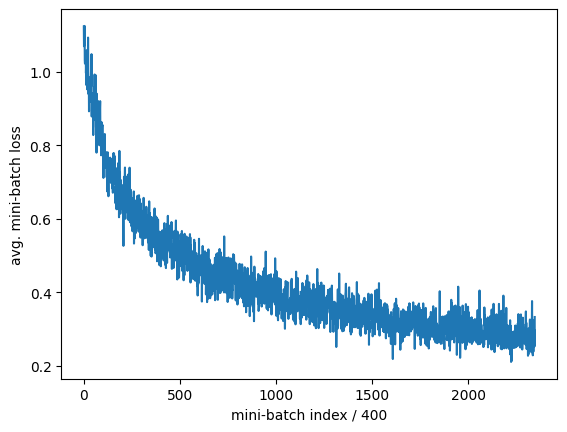

In [8]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [19]:
# Get val accuracy.
correct = 0
total = 0
val_loss = 0.0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = loss_func(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Val Loss: " + str(val_loss/len(test_loader)) + ", Val Accuracy: " +      str((100 * correct / total)))

Val Loss: 0.1618285015118208, Val Accuracy: 89.065


Test Loss: 0.28827554008943573, Test Accuracy: 89.07140936938467


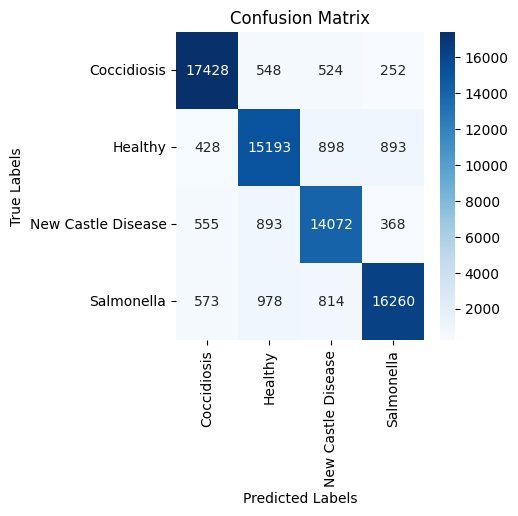

In [13]:
# get tes acc, make confusion matrix
net.eval()
class_labels = dataset.classes
correct_test = 0
total_test = 0
test_loss = 0.0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
print("Test Loss: " + str(test_loss/len(test_loader)) + ", Test Accuracy: " + str(test_accuracy))

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [20]:
print(classification_report(true_labels, predicted_labels,  target_names=class_labels))

                    precision    recall  f1-score   support

       Coccidiosis       0.92      0.93      0.92     18752
           Healthy       0.86      0.87      0.87     17412
New Castle Disease       0.86      0.89      0.87     15888
        Salmonella       0.91      0.87      0.89     18625

          accuracy                           0.89     70677
         macro avg       0.89      0.89      0.89     70677
      weighted avg       0.89      0.89      0.89     70677

